<a href="https://colab.research.google.com/github/soumya17dixit/soumya17dixit.github.io/blob/main/slang_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers
!pip install tensorflow

     |████████████████████████████████| 3.4 MB 5.2 MB/s 
     |████████████████████████████████| 61 kB 312 kB/s 
     |████████████████████████████████| 895 kB 57.5 MB/s 
     |████████████████████████████████| 3.3 MB 35.9 MB/s 
     |████████████████████████████████| 596 kB 45.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from tokenizers import BertWordPieceTokenizer
from tqdm.notebook import tqdm
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
import transformers
from transformers import TFAutoModel, AutoTokenizer
import matplotlib.pyplot as plt

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()
#print("REPLICAS: ", strategy.num_replicas_in_sync)

INFO:absl:Entering into master device scope: /job:worker/replica:0/task:0/device:CPU:0


Running on TPU  grpc://10.66.118.122:8470


In [ ]:
!wget https://raw.githubusercontent.com/abcom-mltutorials/detecting-slang/master/jigsawdata.zip

--2022-01-05 08:12:45--  https://raw.githubusercontent.com/abcom-mltutorials/detecting-slang/master/jigsawdata.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 51915053 (50M) [application/zip]
Saving to: ‘jigsawdata.zip’

jigsawdata.zip      100%[===================>]  49.51M   205MB/s    in 0.2s    

2022-01-05 08:12:46 (205 MB/s) - ‘jigsawdata.zip’ saved [51915053/51915053]



In [ ]:
!unzip '/content/jigsawdata.zip'

Archive:  /content/jigsawdata.zip
   creating: bert toxix/
  inflating: bert toxix/test.csv     
  inflating: bert toxix/train.csv    


In [ ]:
train = pd.read_csv("/content/bert toxix/train.csv")
test = pd.read_csv('/content/bert toxix/test.csv')

In [ ]:
train[train['toxic']==1]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
12,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0
16,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",1,0,0,0,0,0
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1
43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0
...,...,...,...,...,...,...,...,...
159494,fef4cf7ba0012866,"""\n\n our previous conversation \n\nyou fuckin...",1,0,1,0,1,1
159514,ff39a2895fc3b40e,YOU ARE A MISCHIEVIOUS PUBIC HAIR,1,0,0,0,1,0
159541,ffa33d3122b599d6,Your absurd edits \n\nYour absurd edits on gre...,1,0,1,0,1,0
159546,ffb47123b2d82762,"""\n\nHey listen don't you ever!!!! Delete my e...",1,0,0,0,1,0


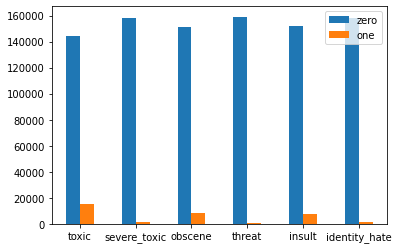

In [ ]:
columns=['toxic','severe_toxic','obscene','threat','insult','identity_hate']
zeros =[]
ones =[]
for col in columns:
  zeros.append(train[col].value_counts()[0])
  ones.append(train[col].value_counts()[1])
  
df = pd.DataFrame({'zero': zeros,'one': ones}, index=columns)
df.plot.bar(rot=0)

In [ ]:
def build_model(transformer, loss, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    x = tf.keras.layers.Dropout(0.35)(cls_token)
    out = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=3e-5), loss=loss, metrics=[tf.keras.metrics.AUC()])
    
    return model

In [ ]:
def focal_loss(gamma=2., alpha=.2):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.mean(alpha * 
                       K.pow(1. - pt_1, gamma) * 
                       K.log(pt_1)) - K.mean((1 - alpha) * 
                       K.pow(pt_0, gamma) * 
                       K.log(1. - pt_0))
    return focal_loss_fixed

In [ ]:
with strategy.scope():
    transformer_layer = transformers.TFBertModel.from_pretrained('bert-base-uncased')
    model = build_model(transformer_layer, loss=focal_loss(gamma=1.5), max_len=512)
model.summary()

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_word_ids (InputLayer)  [(None, 512)]            0         
                                                                 
 tf_bert_model (TFBertModel)  TFBaseModelOutputWithPoo  109482240
                             lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             512, 768),                          
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                                             

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# First load the real tokenizer
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

# Save the loaded tokenizer locally
save_path = 'distilbert_base_uncased/'
if not os.path.exists(save_path):
    os.makedirs(save_path)
tokenizer.save_pretrained(save_path)

# Reload it with the huggingface tokenizers library
fast_tokenizer = BertWordPieceTokenizer('distilbert_base_uncased/vocab.txt', lowercase=True)
fast_tokenizer

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Tokenizer(vocabulary_size=30522, model=BertWordPiece, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], pad_token=[PAD], mask_token=[MASK], clean_text=True, handle_chinese_chars=True, strip_accents=None, lowercase=True, wordpieces_prefix=##)

In [ ]:
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=512):
    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(length=maxlen)
    all_ids = []
    
    for i in tqdm(range(0, len(texts), chunk_size)):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
    
    return np.array(all_ids)

In [ ]:
x = fast_encode(train.comment_text.astype(str), fast_tokenizer, maxlen=512)
x_test = fast_encode(test.comment_text.astype(str), fast_tokenizer, maxlen=512)
y = train.toxic.values

  0%|          | 0/624 [00:00<?, ?it/s]

  0%|          | 0/599 [00:00<?, ?it/s]

In [ ]:
BATCH_SIZE=64

train_dataset = (
    tf.data.Dataset 
      .from_tensor_slices((x, y))
      .repeat()
      .shuffle(2048)
      .batch(BATCH_SIZE)
    # AUTOTUNE prompts the runtime to prepare the next set 
    # while processing the current one
    .prefetch(tf.data.experimental.AUTOTUNE) 
)

test_data = (
    tf.data.Dataset# create dataset
    .from_tensor_slices(x_test) 
    .batch(BATCH_SIZE)
)

In [ ]:
with strategy.scope():
  train_history = model.fit(
      train_dataset,
      
      steps_per_epoch=150,
      
      epochs=10
  )

Epoch 1/10


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'IteratorGetNext:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'IteratorGetNext:1' shape=(None,) dtype=int64>]
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'IteratorGetNext:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'IteratorGetNext:1' shape=(None,) dtype=int64>]


150/150 [==============================] - 124s 255ms/step - loss: 0.0281 - auc: 0.8295
Epoch 2/10
150/150 [==============================] - 38s 255ms/step - loss: 0.0140 - auc: 0.9671
Epoch 3/10
150/150 [==============================] - 38s 256ms/step - loss: 0.0143 - auc: 0.9717
Epoch 4/10
150/150 [==============================] - 38s 256ms/step - loss: 0.0128 - auc: 0.9772
Epoch 5/10
150/150 [==============================] - 38s 256ms/step - loss: 0.0115 - auc: 0.9800
Epoch 6/10
150/150 [==============================] - 38s 255ms/step - loss: 0.0123 - auc: 0.9772
Epoch 7/10
150/150 [==============================] - 38s 256ms/step - loss: 0.0115 - auc: 0.9818
Epoch 8/10
150/150 [==============================] - 38s 255ms/step - loss: 0.0108 - auc: 0.9832
Epoch 9/10
150/150 [==============================] - 38s 256ms/step - loss: 0.0117 - auc: 0.9820
Epoch 10/10
150/150 [==============================] - 38s 256ms/step - loss: 0.0104 - auc: 0.9837


In [ ]:
test['toxic'] = model.predict(test_data, verbose=1)

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond/Identity:0' shape=(None, 512) dtype=int64>]


2394/2394 [==============================] - 207s 84ms/step


In [ ]:
test.to_csv('test.csv', index=False)
data=pd.read_csv('/content/test.csv')
data.head()

,id,comment_text,toxic
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,0.945799
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,0.012356
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",0.020058
3,00017563c3f7919a,":If you have a look back at the source, the in...",0.004922
4,00017695ad8997eb,I don't anonymously edit articles at all.,0.017316


In [ ]:
def replace(toxic):
  if toxic >=0.5:
    toxic=1
  else:
    toxic=0
  return toxic

test['prediction']=test['toxic'].apply(lambda x : replace(x))

In [ ]:
test.head()

,id,comment_text,toxic,prediction
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,0.945799,1
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,0.012356,0
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",0.020058,0
3,00017563c3f7919a,":If you have a look back at the source, the in...",0.004922,0
4,00017695ad8997eb,I don't anonymously edit articles at all.,0.017316,0


Text(0, 0.5, 'count')

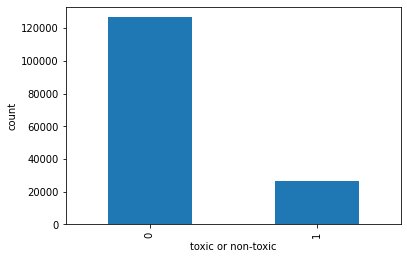

In [ ]:
test.prediction.value_counts().plot(kind='bar')
plt.xlabel('toxic or non-toxic')
plt.ylabel('count')

In [ ]:
text1=test.comment_text[186]
text1

'Are you also suggesting all paintings of black moors are fake too? are you saying that they should be white?'

In [ ]:
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=512):
    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(length=maxlen)
    all_ids = []
    
    #for i in tqdm(range(0, len(texts), chunk_size)):
    #text_chunk = texts[i:i+chunk_size].tolist()
    encs = tokenizer.encode_batch(texts)
    all_ids.extend([enc.ids for enc in encs])

    return np.array(all_ids)

In [ ]:
p1=fast_encode([text1], fast_tokenizer, maxlen=512)
p1 = model.predict(p1)
if (replace(p1) == 0):
  print ("Okay contents")
else:
  print ("Contents not permitted")

Okay contents


In [ ]:
text2=test.comment_text[0]
text2

"Yo bitch Ja Rule is more succesful then you'll ever be whats up with you and hating you sad mofuckas...i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me. Ja rule is about pride in da music man. dont diss that shit on him. and nothin is wrong bein like tupac he was a brother too...fuckin white boys get things right next time.,"

In [ ]:
p2=fast_encode([text2], fast_tokenizer, maxlen=512)
p2=model.predict(p2)
if (replace(p2) == 0):
  print ("Okay contents")
else:
  print ("Contents not permitted")

Contents not permitted


In [ ]:
text3 =["Every once in a while, I get the urge. You know what I'm talking about, don't you? The urge for destruction. The urge to hurt, maim, kill. It's quite a thing to experience that urge, to let it wash over you, to give in to it. It's addictive. It's all-consuming. You lose yourself to it. It's quite, quite wonderful. I can feel it, even as I speak, tapping around the edges of my mind, trying to prise me open, slip its fingers in. And it would be so easy to let it happen. But we're all like that, aren't we? We're all barbarians at our core. We're all savage, murderous beasts. I know I am. I'm sure you are. The only difference between us, Mr. Prave, is how loudly we roar. I know I roar very loudly indeed. How about you. Do you think you can match me"]
text3

["Every once in a while, I get the urge. You know what I'm talking about, don't you? The urge for destruction. The urge to hurt, maim, kill. It's quite a thing to experience that urge, to let it wash over you, to give in to it. It's addictive. It's all-consuming. You lose yourself to it. It's quite, quite wonderful. I can feel it, even as I speak, tapping around the edges of my mind, trying to prise me open, slip its fingers in. And it would be so easy to let it happen. But we're all like that, aren't we? We're all barbarians at our core. We're all savage, murderous beasts. I know I am. I'm sure you are. The only difference between us, Mr. Prave, is how loudly we roar. I know I roar very loudly indeed. How about you. Do you think you can match me"]

In [ ]:
p3=fast_encode(text3, fast_tokenizer, maxlen=512)
p3=model.predict(p3)
if (replace(p2) == 0):
  print ("Okay contents")
else:
  print ("Contents not permitted")

Contents not permitted
